Import the required modules

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import PIL
import PIL.Image
import json

2024-01-20 10:29:38.933517: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-20 10:29:38.959381: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def load_angles_from_folder(directory):
    with open(directory,'r')  as ff:
        content = ff.readline()
        angles = content.split(sep='\t') #lines are separated by tabs
        angles = np.asarray(angles, dtype = np.float32) * (np.pi/180)
        return angles

In [3]:
def load_images_from_folder(directory):
    images = []
    fileslist = os.listdir(directory)
    fileslist = sorted(fileslist , key = lambda fileslist: int(fileslist.split('.')[0]))
    #key=lambda x: int(x.split('_')[1]
    for filename in fileslist:
        #img = cv.imread(os.path.join(directory,filename))
        loc = os.path.join(directory,filename)
        img = tf.keras.preprocessing.image.load_img(loc, target_size=(300, 300), interpolation = 'nearest')
        img = tf.keras.preprocessing.image.img_to_array(img) / 255.0
        if img is not None:
            images.append(img)
    return np.asarray(images)

2.0868206


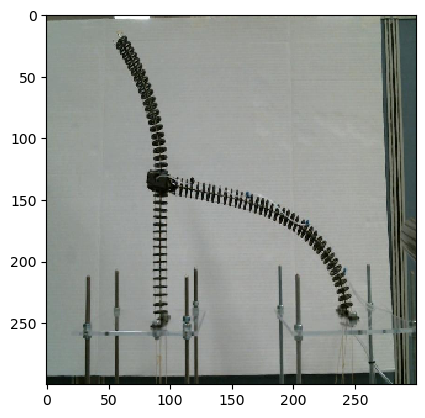

In [4]:
directory_imgs = './Dataset/imgs/'
directory_angles = './Dataset/Labels.txt'
imgs = load_images_from_folder(directory_imgs)
angles = load_angles_from_folder(directory_angles)
plt.imshow(imgs[240])
print(angles[240])

Defining the Convolutional Neural Network

In [5]:
base_model = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top = False, input_shape = (300,300,3))
base_model.trainable = False
X = base_model.layers[-5].output
X = tf.keras.layers.Flatten()(X)
X = tf.keras.layers.Dense(1, 'linear', use_bias=True)(X)
model = tf.keras.Model(base_model.input, X)
opt = tf.keras.optimizers.Adam(learning_rate = 1e-6)
lossfunction = tf.keras.losses.MeanSquaredError()
#model.summary()

2024-01-20 10:29:42.198446: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-20 10:29:42.201336: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-20 10:29:42.201419: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Compile the model

In [6]:
model.compile(optimizer = opt, loss = lossfunction, metrics = ['MeanAbsoluteError'])

Train and Save the model

In [7]:
imgs_t = np.delete(imgs , np.arange(900, 999), axis = 0)
angles_t = np.delete(angles , np.arange(900, 999), axis = 0)
angles_t.shape


(900,)

In [8]:
del imgs

In [9]:
history = model.fit(imgs_t,angles_t, batch_size = 16,epochs = 400)

Epoch 1/400


2024-01-20 10:29:43.914250: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8906


 1/57 [..............................] - ETA: 2:20 - loss: 17.1171 - mean_absolute_error: 3.5707

2024-01-20 10:29:45.979083: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x9ab1680 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-20 10:29:45.979098: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-01-20 10:29:45.981593: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-20 10:29:46.048827: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


57/57 [==============================] - 7s 88ms/step - loss: 7.4820 - mean_absolute_error: 2.2317
Epoch 2/400
57/57 [==============================] - 5s 81ms/step - loss: 3.7363 - mean_absolute_error: 1.6225
Epoch 3/400
57/57 [==============================] - 5s 79ms/step - loss: 2.6954 - mean_absolute_error: 1.3504
Epoch 4/400
57/57 [==============================] - 5s 82ms/step - loss: 1.9293 - mean_absolute_error: 1.1216
Epoch 5/400
57/57 [==============================] - 5s 81ms/step - loss: 1.3470 - mean_absolute_error: 0.9145
Epoch 6/400
57/57 [==============================] - 5s 79ms/step - loss: 0.9374 - mean_absolute_error: 0.7489
Epoch 7/400
57/57 [==============================] - 5s 81ms/step - loss: 0.6527 - mean_absolute_error: 0.6120
Epoch 8/400
57/57 [==============================] - 5s 82ms/step - loss: 0.4659 - mean_absolute_error: 0.5167
Epoch 9/400
57/57 [==============================] - 5s 81ms/step - loss: 0.3378 - mean_absolute_error: 0.4405
Epoch 10/400


Save the model for test (Training takes time)

In [10]:
model.save('./TrainedCNNs/c910_new', save_format = 'h5' )

/home/shayan/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
